
<center>

# **Trabajo 02: Prediccion de accidentes**
---

Fundamentos de Analítica
---
---
**Estudiantes:**

Alejandro Zapata Quintero

---

Camilo Andres Granada Mejia

---

Andrés Felipe Torres Chaverra

---

Isabella Saez Calderon

---

Juan José Flórez Ospina

---
</center>

#Se cargan las librerías necesarias

In [1]:
# Cargar librerias
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb
from scipy import stats

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import StratifiedKFold
# librerías Árboles de Decisión
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont


# librerías Gaussian Naive Bayes
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay   #La vieja funcion para la matriz de confusion fue descontinuada
from sklearn.metrics import make_scorer

#Carga de los datos
El siguiente bloque de código se usa para importar archivos al colab usando el gestor de archivos de explorer.exe de windows o su derivado en linux.
Por algún motivo quienes procesaron los datos inicialmente los guardaron con codificacion latin-1, cosa que es muy contraproducente.

In [2]:
#Para abrir desde colab sin tenerlo en la nube.
from google.colab import files
import io
uploaded = files.upload()
dataframe = pd.read_csv(io.BytesIO(uploaded['incidentes_viales.csv']), encoding='latin-1')

KeyboardInterrupt: ignored

#Luego de cargar el archivo revisamos la estructuracion de los datos

In [ ]:
#limpiando caracteres especiales corruptos para facilitar el manejo de columnas
dataframe.rename(columns = {'AÃO':'YEAR'}, inplace = True)
dataframe.rename(columns = {'DISEÃO':'DISENO'}, inplace = True)

In [ ]:
dataframe.head()

,YEAR,CBML,CLASE_ACCIDENTE,DIRECCION,DIRECCION ENCASILLADA,DISENO,EXPEDIENTE,FECHA_ACCIDENTE,FECHA_ACCIDENTES,GRAVEDAD_ACCIDENTE,MES,NRO_RADICADO,NUMCOMUNA,BARRIO,COMUNA,LOCATION,X,Y
0,2015,1013,Caida Ocupante,CR 46 CL 43,CR 046 043 000 00000,Tramo de via,A000259731,21/10/2015 05:58:00,2015-10-21T10:58:00.000Z,Con heridos,10,1508668,10,Barrio ColÃ³n,La Candelaria,"[-75.5688011014, 6.24312304123]",834949.69,1182357.34
1,2015,1020,Choque,CR 43 A CL 29,CR 043 A 029 000 00000,Tramo de via,A000261725,05/11/2015 03:00:00,2015-11-05T08:00:00.000Z,Solo daÃ±os,11,1510621,10,San Diego,La Candelaria,"[-75.5693883283, 6.22870030622]",834880.17,1180762.02
2,2015,0205,Otro,CR 46 CL 37,CR 046 037 000 00000,Tramo de via,A000259739,21/10/2015 07:40:00,2015-10-21T12:40:00.000Z,Con heridos,10,1508691,02,La Francia,Santa Cruz,"[-75.5503911403, 6.29869502502]",837004.94,1188499.17
3,2015,0101,Atropello,CR 34 CL 112,CR 034 112 000 00000,Tramo de via,A000259752,21/10/2015 12:00:00,2015-10-21T17:00:00.000Z,Con heridos,10,1508694,01,Santo Domingo Savio No. 1,Popular,"[-75.5442195069, 6.30019383306]",837688.53,1188663.05
4,2015,1504,Choque,CR 50 CL 14,CR 050 014 000 00000,Tramo de via,A000259949,03/11/2015 06:16:00,2015-11-03T11:16:00.000Z,Solo daÃ±os,11,1510634,15,Santa FÃ©,Guayabal,"[-75.578180998, 6.21699243701]",833903.11,1179469.60


#Se Revisa la distribución de los datos
Es de esperarse que las columnas con formato latin-1 sean ignoradas pues no es aceptable para pandas ni las librerías estadísticas.
Un primer vistazo muestra una uniformidad en los datos.

In [ ]:
dataframe.describe()

,MES,X,Y
count,270765.000000,270765.000000,2.707650e+05
mean,6.683630,833004.237424,1.182894e+06
std,3.414502,4182.702104,3.167370e+03
min,1.000000,820000.000000,1.172269e+06
25%,4.000000,832332.380000,1.180451e+06
50%,7.000000,834160.900000,1.182905e+06
75%,10.000000,835256.190000,1.185181e+06
max,12.000000,843984.830000,1.196215e+06


Homogenizacion de los años

In [ ]:
dataframe.replace({r'\\\r': ''}, regex=True)
dataframe = dataframe.replace('2014',2014)
dataframe = dataframe.replace('2015',2015)
dataframe = dataframe.replace('2016',2016)
dataframe = dataframe.replace('2017',2017)
dataframe = dataframe.replace('2018',2018)
dataframe = dataframe.replace('2019',2019)
dataframe = dataframe.replace('2020',2020)

#Se eliminan las columnas "basura"
Se eliminan las columnas que corresponden a informacion que solo es relevante para la entidad que usó los datos originalmente y la información repetida que ya está representada numéricamente.

---

las direcciones especificas son irrelevantes en el modelo pues solo se necesita la informacion de las comunas, por ahora se dejan ambas columnas para las comunas pero finalmente se usará solo la numérica.

---

El diseño del tramo vial es irrelevante al igual que la gravedad puesto que ese es un modelo diferente.

---

La columna FECHA_ACCIDENTES se elimina al ser una repeticion de la columna FECHA_ACCIDENTE pero con un formato diferente

---

Expediente, cbml y Radicado solo son relevantes para la entidad de transito correspondiente y location es redundante respecto al otro sistema de coordenadas

In [ ]:
dataframe.drop(['DIRECCION','DIRECCION ENCASILLADA','DISENO','FECHA_ACCIDENTES','GRAVEDAD_ACCIDENTE','EXPEDIENTE','NRO_RADICADO','LOCATION','CBML'], axis=1, inplace=True)

#Se verifica la existencia de nulos


In [ ]:
dataframe.isnull().sum()

YEAR                   0
CLASE_ACCIDENTE        6
FECHA_ACCIDENTE        0
MES                    0
NUMCOMUNA              0
BARRIO             19006
COMUNA             12798
X                      0
Y                      0
dtype: int64

Se eliminan los nulos encontrados para evitar inconsistencias

In [ ]:
dataframe.dropna(axis=0,inplace=True)
dataframe.isnull().sum()

YEAR               0
CLASE_ACCIDENTE    0
FECHA_ACCIDENTE    0
MES                0
NUMCOMUNA          0
BARRIO             0
COMUNA             0
X                  0
Y                  0
dtype: int64

# Analisis de la  accidentalidad

Se crea un dataframe temporal en el que se filtra la comuna 0 (cero) que corresponde a un accidente cuya comuna no fue reportada

In [ ]:
df_filtered = dataframe[dataframe['COMUNA'] != "0"]

Primero se observan los accidentes en los barrios por año, aunque las limitaciones de la consola impiden ver a fondo los datos barrio por barrio sin tener que hacer un recorrido manual, se puede observar una inconsistencia en los nombres de los barrios en los que se encuentran por su nombre propio en algunos casos y por su código en otros, por lo tanto la columna barrio se descarta

In [ ]:
df_filtered.groupby(['BARRIO','YEAR']).describe()

MES                           \
                                              count      mean       std  min   
BARRIO                                   YEAR                                  
0                                        2015   6.0  9.000000  2.097618  6.0   
                                         2016   3.0  4.000000  1.000000  3.0   
                                         2018   2.0  9.500000  0.707107  9.0   
                                         2019   1.0  2.000000       NaN  2.0   
                                         2020  15.0  3.800000  2.177810  1.0   
...                                             ...       ...       ...  ...   
Ãrea de ExpansiÃ³n San Antonio de Prado 2015  14.0  5.928571  3.771641  1.0   
                                         2016  15.0  5.933333  3.614784  1.0   
                                         2017   6.0  5.500000  2.509980  3.0   
                                         2018  15.0  8.000000  3.683942  2.0   
                                         2020  12.0  4.166667  2.443296  1.0   

                                                                          X  \
                                                25%  50%    75%   max count   
BARRIO                                   YEAR                                 
0                                        2015  8.00  9.0  10.00  12.0   6.0   
                                         2016  3.50  4.0   4.50   5.0   3.0   
                                         2018  9.25  9.5   9.75  10.0   2.0   
                                         2019  2.00  2.0   2.00   2.0   1.0   
                                         2020  2.00  3.0   5.50   7.0  15.0   
...                                             ...  ...    ...   ...   ...   
Ãrea de ExpansiÃ³n San Antonio de Prado 2015  3.00  6.0   8.50  12.0  14.0   
                                         2016  3.50  5.0   8.50  12.0  15.0   
                                         2017  3.25  5.5   7.00   9.0   6.0   
                                         2018  5.50  9.0  10.50  12.0  15.0   
                                         2020  2.00  4.5   5.25   8.0  12.0   

                                                              ...  \
                                                        mean  ...   
BARRIO                                   YEAR                 ...   
0                                        2015  824974.631667  ...   
                                         2016  824821.883333  ...   
                                         2018  825911.680000  ...   
                                         2019  825911.680000  ...   
                                         2020  830804.203333  ...   
...                                                      ...  ...   
Ãrea de ExpansiÃ³n San Antonio de Prado 2015  825490.024286  ...   
                                         2016  825458.336667  ...   
                                         2017  825367.968333  ...   
                                         2018  825469.669333  ...   
                                         2020  825315.321667  ...   

                                                                          Y  \
                                                       75%        max count   
BARRIO                                   YEAR                                 
0                                        2015  824807.8600  825917.84   6.0   
                                         2016  824883.5700  824883.57   3.0   
                                         2018  825911.6800  825911.68   2.0   
                                         2019  825911.6800  825911.68   1.0   
                                         2020  833505.3700  833505.37  15.0   
...                                                    ...        ...   ...   
Ãrea de ExpansiÃ³n San Antonio de Prado 2015  825593.3000  825654.62  14.0   
                                         2016  825593.3000  825

In [ ]:
dataframe.drop(['BARRIO'], axis=1, inplace=True)

Se revisa ahora la accidentalidad por año y por comuna, de entrada puede verse como hay un crecimiento progresivo a lo largo de los años y como comunas como la candelaria (ver mas abajo) encabezan la lista de accidentalidad por su cantidad, tambien puede verse como en el año 2020 hay una disminucion dramática de los accidentes lo cual concuerda con lo sucedido durante ese año (pandemia covid 19).

In [ ]:
df_filtered.groupby(['COMUNA','YEAR']).describe()

MES                                                   \
                       count      mean       std  min   25%  50%    75%   max   
COMUNA        YEAR                                                              
AU            2014       2.0  8.500000  0.707107  8.0  8.25  8.5   8.75   9.0   
              2017       2.0  4.000000  2.828427  2.0  3.00  4.0   5.00   6.0   
Aranjuez      2014    1139.0  9.496927  1.702046  7.0  8.00  9.0  11.00  12.0   
              2015    2377.0  6.591502  3.408271  1.0  4.00  7.0   9.00  12.0   
              2016    2451.0  6.597715  3.500399  1.0  3.00  7.0  10.00  12.0   
...                      ...       ...       ...  ...   ...  ...    ...   ...   
Villa Hermosa 2017    1037.0  6.543877  3.459257  1.0  4.00  7.0   9.00  12.0   
              2018    1022.0  6.439335  3.282897  1.0  4.00  7.0   9.00  12.0   
              2019     804.0  7.182836  3.279075  1.0  5.00  8.0  10.00  12.0   
              2020     675.0  4.160000  2.414324  1.0  2.00  4.0   6.00   8.0   
              2019\r   395.0  6.645570  3.372169  1.0  4.00  7.0  10.00  12.0   

                           X                 ...                         \
                       count           mean  ...         75%        max   
COMUNA        YEAR                           ...                          
AU            2014       2.0  826797.160000  ...  827140.750  827484.34   
              2017       2.0  827484.340000  ...  827484.340  827484.34   
Aranjuez      2014    1139.0  835708.296330  ...  836213.470  836734.19   
              2015    2377.0  835737.423504  ...  836181.090  836739.40   
              2016    2451.0  835714.560298  ...  836173.690  836739.40   
...                      ...            ...  ...         ...        ...   
Villa Hermosa 2017    1037.0  837189.377377  ...  837735.570  839390.52   
              2018    1022.0  837236.141654  ...  837770.840  839390.52   
              2019     804.0  837296.782326  ...  837803.150  839374.07   
              2020     675.0  837352.320000  ...  837892.125  839372.66   
              2019\r   395.0  837092.553392  ...  837723.960  839275.70   

                           Y                                         \
                       count          mean          std         min   
COMUNA        YEAR                                                    
AU            2014       2.0  1.181180e+06  7082.756287  1176171.44   
              2017       2.0  1.186188e+06     0.000000  1186187.97   
Aranjuez      2014    1139.0  1.185652e+06   823.682568  1184438.92   
              2015    2377.0  1.185750e+06   832.784983  1184440.03   
              2016    2451.0  1.185733e+06   882.125074  1180000.00   
...                      ...           ...          ...         ...   
Villa Hermosa 2017    1037.0  1.182893e+06   859.896460  1180992.03   
              2018    1022.0  1.182821e+06   873.806411  1180941.96   
              2019     804.0  1.182726e+06   842.555577  1180987.74   
              2020     675.0  1.182731e+06   879.312251  1180939.28   
              2019\r   395.0  1.183009e+06   919.477511  1180941.96   

                                                                           
                               25%          50%           75%         max  
COMUNA        YEAR                                                         
AU            2014    1.178676e+06  1181179.705  1.183684e+06  1186187.97  
              2017    1.186188e+06  1186187.970  1.186188e+06  1186187.97  
Aranjuez      2014    1.184788e+06  1185653.150  1.186132e+06  1187665.05  
              2015    1.184958e+06  1185693.650  1.186411e+06  1187665.05  
              2016    1.184820e+06  1185665.980  1.186495e+06  1187665.05  
...                            ...          ...           ...         ...  
Villa Hermosa 2017    1.182319e+06  1183011.380  1.183659e+06  1184352.69  
              2018    1.182196e+06  1182932.260  1.183592e+06  1184364.94  
        

Se filtra solo por comuna mostrando efectivamente cuales son los lugares con la mayor accidentalidad

In [ ]:
df_filtered.groupby(['COMUNA']).describe()

MES                       \
                                                 count       mean       std   
COMUNA                                                                        
AU                                                 4.0   6.250000  3.095696   
Aranjuez                                       14372.0   6.662817  3.428322   
Bel\xE9n                                        2675.0   6.948037  3.374737   
BelÃ©n                                         14114.0   6.630438  3.416176   
Buenos Aires                                    9887.0   6.606756  3.414383   
Castilla                                       24908.0   6.666854  3.453269   
Corregimiento de Altavista                       571.0   6.695271  3.383909   
Corregimiento de San Antonio de Prado           4047.0   6.635038  3.300937   
Corregimiento de San Crist\xF3bal                413.0   6.583535  3.449486   
Corregimiento de San CristÃ³bal                 2210.0   6.397285  3.420122   
Corregimiento de San Sebasti\xE1n de Palmitas      2.0   4.000000  2.828427   
Corregimiento de San SebastiÃ¡n de Palmitas       15.0   6.733333  3.769552   
Corregimiento de Santa Elena                     605.0   6.479339  3.441804   
Doce de Octubre                                 6896.0   6.595128  3.397128   
El Poblado                                     21711.0   6.640827  3.411020   
Guayabal                                       18505.0   6.725804  3.419878   
In                                                40.0   8.025000  3.261960   
La Am\xE9rica                                   1352.0   6.658284  3.363729   
La AmÃ©rica                                     6698.0   6.561511  3.401753   
La Candelaria                                  52173.0   6.760757  3.406098   
Laureles Estadio                               27049.0   6.674517  3.399019   
Manrique                                        7779.0   6.758067  3.402476   
Popular                                         3719.0   6.689433  3.413745   
Robledo                                        16510.0   6.658268  3.421984   
SN                                                 1.0  10.000000       NaN   
San Javier                                      4324.0   6.710685  3.437525   
Santa Cruz                                      3444.0   6.800523  3.441641   
Villa Hermosa                                   6711.0   6.646550  3.392277   

                                                                               \
                                                min    25%   50%    75%   max   
COMUNA                                                                          
AU                                              2.0   5.00   7.0   8.25   9.0   
Aranjuez                                        1.0   4.00   7.0  10.00  12.0   
Bel\xE9n                                        1.0   4.00   7.0  10.00  12.0   
BelÃ©n                                          1.0   4.00   7.0   9.00  12.0   
Buenos Aires                                    1.0   4.00   7.0   9.00  12.0   
Castilla                                        1.0   4.00   7.0  10.00  12.0   
Corregimiento de Altavista                      1.0   4.00   7.0  10.00  12.0   
Corregimiento de San Antonio de Prado           1.0   4.00   7.0   9.00  12.0   
Corregimiento de San Crist\xF3bal               1.0   4.00   7.0   9.00  12.0   
Corregimiento de San CristÃ³bal                 1.0   3.00   7.0   9.00  12.0   
Corregimiento de San Sebasti\xE1n de Palmitas   2.0   3.00   4.0   5.00   6.0   
Corregimiento de San SebastiÃ¡n de Palmitas     1.0   3.00   8.0   9.50  12.0   
Corregimiento de Santa Elena                    1.0   3.00   7.0   9.00  12.0   
Doce de Octubre                                 1.0   4.00   7.0   9.00  12.0   
El Poblado                                      1.0   4.00   7.0  10.00  12.0   
Guayabal                                        1.0   4.00   7.0  10.00  12.0   
In                                              1.0   5.75   9

Desafortunadamente un mal manejo de datos por parte de quien creó el dataset provocó que muchos datos tuvieran codificacion defectuosa, casi todos son nombres que no afectan al modelo pero en el caso de los años un caracter especial en el lugar equivocado hizo que el año 2019 se dividiera en dos partes y por desgracia pandas es incapaz de solucionar el problema pues no es capaz de detectar el \r debido a que esta pegado al string.

Aun así se puede ver muy claramente lo anteriormente dicho y es que hay una clara tendencia a que aumenten los accidentes a lo largo de los años, esto tiene sentido debido a multiples factores como el crecimiento del parque automotor o el poblacional pero tambien puede verse como la pandemia redujo dramáticamente la accidentalidad

In [ ]:
df_filtered.groupby(['YEAR']).describe()

MES                                                       X  \
          count      mean       std  min  25%  50%   75%   max    count   
YEAR                                                                      
2014    20754.0  9.517828  1.693009  7.0  8.0  9.0  11.0  12.0  20754.0   
2015    42680.0  6.628280  3.395843  1.0  4.0  7.0  10.0  12.0  42680.0   
2016    43528.0  6.602715  3.399259  1.0  4.0  7.0  10.0  12.0  43528.0   
2017    42691.0  6.556487  3.407199  1.0  4.0  7.0   9.0  12.0  42691.0   
2018    40202.0  6.591140  3.407626  1.0  4.0  7.0  10.0  12.0  40202.0   
2019    16991.0  6.977223  3.394870  1.0  4.0  7.0  10.0  12.0  16991.0   
2020    18458.0  3.985210  2.455929  1.0  2.0  3.0   6.0   8.0  18458.0   
2019\r  25431.0  6.730408  3.397008  1.0  4.0  7.0  10.0  12.0  25431.0   

                       ...                                Y                \
                 mean  ...          75%        max    count          mean   
YEAR                   ...                                                  
2014    834023.714990  ...  835398.5050  839449.89  20754.0  1.183164e+06   
2015    833985.558689  ...  835359.8000  841270.89  42680.0  1.183116e+06   
2016    833956.644804  ...  835324.5500  839628.27  43528.0  1.183052e+06   
2017    833952.815065  ...  835254.0200  841724.40  42691.0  1.183076e+06   
2018    834020.556499  ...  835314.2000  841724.40  40202.0  1.183195e+06   
2019    834395.405020  ...  835744.7950  839496.86  16991.0  1.183639e+06   
2020    834149.505598  ...  835651.1175  842538.35  18458.0  1.183315e+06   
2019\r  833895.410046  ...  835220.5400  842045.15  25431.0  1.182775e+06   

                                                                         \
                std         min           25%         50%           75%   
YEAR                                                                      
2014    3166.557129  1174230.50  1.181198e+06  1183177.14  1.185499e+06   
2015    3150.695451  1174017.59  1.181184e+06  1183134.99  1.185446e+06   
2016    3203.389290  1174001.40  1.181076e+06  1183044.46  1.185432e+06   
2017    3209.330177  1173919.32  1.181094e+06  1183127.91  1.185449e+06   
2018    3163.603813  1174000.70  1.181141e+06  1183137.36  1.185588e+06   
2019    3271.721991  1174000.07  1.181841e+06  1183748.70  1.186039e+06   
2020    3114.419292  1174250.45  1.181296e+06  1183198.15  1.185707e+06   
2019\r  2995.672424  1174254.66  1.181004e+06  1182836.39  1.184688e+06   

                    
               max  
YEAR                
2014    1189951.19  
2015    1193450.74  
2016    1193450.74  
2017    1193390.93  
2018    1193440.25  
2019    1189972.54  
2020    1191444.64  
2019\r  1196214.64  

[8 rows x 24 columns]

Adicionalmente se revisa la accidentalidad por mes, aquí es irrelevante el año asi que se toma 2018 y puede observarse como a pesar de que el comportamiento es relativamente estable hay una tendencia a aumentar la accidentalidad en la segunda mitad del año

In [ ]:
df_filtered.groupby(['MES'], 'YEAR'==2018).describe()

X                                                                 \
       count           mean          std        min         25%         50%   
MES                                                                           
1    18613.0  834018.097593  2172.984682  820000.00  832924.060  834311.510   
2    20658.0  833999.263630  2137.423675  820000.00  832888.700  834246.700   
3    19874.0  834011.528392  2132.929058  820000.00  832903.760  834260.415   
4    17865.0  833974.641652  2158.716768  824708.90  832876.690  834246.760   
5    19666.0  834029.128872  2165.622843  820000.00  832928.190  834286.110   
6    18810.0  834026.771939  2172.142409  820000.00  832958.490  834315.795   
7    23270.0  833996.736299  2194.120878  820000.00  832876.690  834266.290   
8    25091.0  834005.365959  2170.268598  821475.59  832920.755  834260.880   
9    22423.0  834004.336009  2149.636285  820000.00  832898.980  834266.290   
10   22261.0  833992.653558  2143.333068  820000.00  832903.420  834260.780   
11   20703.0  834046.512859  2110.097284  820000.00  833007.760  834303.150   
12   21501.0  834069.265880  2100.800691  821475.59  833030.100  834320.880   

                                   Y                                         \
             75%        max    count          mean          std         min   
MES                                                                           
1    835384.8100  842351.63  18613.0  1.183178e+06  3204.727533  1174054.50   
2    835357.1850  841270.89  20658.0  1.183078e+06  3175.771596  1174021.58   
3    835368.2775  841724.40  19874.0  1.183226e+06  3172.130597  1174254.66   
4    835323.9300  842354.84  17865.0  1.183126e+06  3175.071417  1174045.89   
5    835403.6500  841724.40  19666.0  1.183156e+06  3140.036385  1174000.70   
6    835387.6850  842538.35  18810.0  1.183150e+06  3199.352405  1174055.65   
7    835400.2500  841724.40  23270.0  1.183093e+06  3167.816499  1174001.40   
8    835379.7600  841575.08  25091.0  1.183069e+06  3190.050493  1174000.07   
9    835368.6100  841724.40  22423.0  1.183070e+06  3167.856017  1174021.58   
10   835324.3900  841724.40  22261.0  1.183112e+06  3163.514007  1174001.40   
11   835343.2600  841724.40  20703.0  1.183134e+06  3145.622351  1173919.32   
12   835388.3900  841724.50  21501.0  1.183201e+06  3127.918103  1174254.66   

                                                       
              25%         50%         75%         max  
MES                                                    
1    1.181114e+06  1183137.36  1185651.86  1193450.74  
2    1.181089e+06  1183068.86  1185439.61  1191684.46  
3    1.181178e+06  1183189.30  1185637.93  1193450.74  
4    1.181121e+06  1183127.66  1185480.20  1189972.54  
5    1.181165e+06  1183149.93  1185450.75  1193390.93  
6    1.181129e+06  1183128.19  1185572.63  1196214.64  
7    1.181113e+06  1183127.91  1185416.49  1190016.48  
8    1.181112e+06  1183101.13  1185375.40  1193450.74  
9    1.181113e+06  1183078.60  1185375.40  1189972.54  
10   1.181117e+06  1183131.37  1185436.64  1189972.54  
11   1.181118e+06  1183128.45  1185431.85  1193440.25  
12   1.181179e+06  1183135.98  1185523.36  1193450.74

Ahora se analizaran fechas especiales, en primer lugar se toma como ejemplo el día 3 de junio de 2019 que corresponde a un lunes festivo y se compara con el lunes anterior y siguiente.

De inmediato se observa un comportamiento que a primera vista parece contraintuitivo pero tiene sentido y es que el día festivo hay menos accidentes, esto se debe a la gran cantidad de personas que dejan la ciudad para aprovechar el dia libre o que se queda en sus casas para descansar.

In [ ]:
print("03 (festivo)")
print(dataframe[dataframe['FECHA_ACCIDENTE'].str.contains("03/06/2019")].count())
print("27 lunes anterior")
print(dataframe[dataframe['FECHA_ACCIDENTE'].str.contains("27/05/2019")].count())
print("10 lunes siguiente")
print(dataframe[dataframe['FECHA_ACCIDENTE'].str.contains("10/06/2019")].count())

03 (festivo)
YEAR               70
CLASE_ACCIDENTE    70
FECHA_ACCIDENTE    70
MES                70
NUMCOMUNA          70
COMUNA             70
X                  70
Y                  70
dtype: int64
27 lunes anterior
YEAR               109
CLASE_ACCIDENTE    109
FECHA_ACCIDENTE    109
MES                109
NUMCOMUNA          109
COMUNA             109
X                  109
Y                  109
dtype: int64
10 lunes siguiente
YEAR               117
CLASE_ACCIDENTE    117
FECHA_ACCIDENTE    117
MES                117
NUMCOMUNA          117
COMUNA             117
X                  117
Y                  117
dtype: int64


Si se hace lo mismo para una fecha especial mas reconocida como lo es la navidad se ve el mismo comportamiento, en los dias que estan a su alrededor la accidentalidad mantiene un comportamiento similar, pero el dia festivo (navidad) la accidentalidad disminuye por los factores que ya se habían mencionado.
El comportamiento en los demás dias especiales debería ser el mismo.

In [ ]:
print("23")
print(dataframe[dataframe['FECHA_ACCIDENTE'].str.contains("23/12/2019")].count())
print("24")
print(dataframe[dataframe['FECHA_ACCIDENTE'].str.contains("24/12/2019")].count())
print("25")
print(dataframe[dataframe['FECHA_ACCIDENTE'].str.contains("25/12/2019")].count())
print("26")
print(dataframe[dataframe['FECHA_ACCIDENTE'].str.contains("26/12/2019")].count())

23
YEAR               141
CLASE_ACCIDENTE    141
FECHA_ACCIDENTE    141
MES                141
NUMCOMUNA          141
COMUNA             141
X                  141
Y                  141
dtype: int64
24
YEAR               126
CLASE_ACCIDENTE    126
FECHA_ACCIDENTE    126
MES                126
NUMCOMUNA          126
COMUNA             126
X                  126
Y                  126
dtype: int64
25
YEAR               83
CLASE_ACCIDENTE    83
FECHA_ACCIDENTE    83
MES                83
NUMCOMUNA          83
COMUNA             83
X                  83
Y                  83
dtype: int64
26
YEAR               119
CLASE_ACCIDENTE    119
FECHA_ACCIDENTE    119
MES                119
NUMCOMUNA          119
COMUNA             119
X                  119
Y                  119
dtype: int64


# Se crean crosstabs para usar chi2 con las variables categoricas
Las crosstabs compararan la variables para ver su relevancia.


Los resultados obtenidos muestran un valor P muy pequeño por lo que se asume que los datos son relevantes al modelo

La fecha tecnicamente no tiene formato así que no se considera en el análisis, pero por lo visto anteriormente es más que evidente que es relevante al modelo

In [ ]:
crosstab2 = pd.crosstab(dataframe['CLASE_ACCIDENTE'], dataframe['COMUNA'])

In [ ]:
stats.chi2_contingency(crosstab2)

Chi2ContingencyResult(statistic=16689.188818895127, pvalue=0.0, dof=196, expected_freq=array([[9.74356929e+01, 3.82851446e-01, 1.37558524e+03, 2.56031904e+02,
        1.35089133e+03, 9.46313061e+02, 2.38401595e+03, 5.46520439e+01,
        3.87349950e+02, 3.95294118e+01, 2.11525424e+02, 1.91425723e-01,
        1.43569292e+00, 5.79062812e+01, 6.60035892e+02, 2.07802193e+03,
        1.77116650e+03, 3.82851446e+00, 1.29403789e+02, 6.41084746e+02,
        4.99362712e+03, 2.58893719e+03, 7.44550349e+02, 3.55956132e+02,
        1.58021934e+03, 9.57128614e-02, 4.13862413e+02, 3.29635095e+02,
        6.42329013e+02],
       [6.41483994e+01, 2.52056579e-01, 9.05639289e+02, 1.68562837e+02,
        8.89381640e+02, 6.23020850e+02, 1.56955632e+03, 3.59810767e+01,
        2.55018244e+02, 2.60248418e+01, 1.39261260e+02, 1.26028290e-01,
        9.45212172e-01, 3.81235576e+01, 4.34545543e+02, 1.36810010e+03,
        1.16607675e+03, 2.52056579e+00, 8.51951238e+01, 4.22068742e+02,
        3.28763698e+03, 

#Se convierten todas las variables categoricas a numéricas
Esto es necesario pues el algoritmo que se va a usar posteriormente no contempla strings

In [ ]:
dataframe = dataframe.replace('CaÃ­da de Ocupante','Caida Ocupante')
dataframe = dataframe.replace('CaÃ­da Ocupante','Caida Ocupante')

In [ ]:
dataframe = dataframe.replace('2014','2014')
dataframe = dataframe.replace('2015','2015')
dataframe = dataframe.replace('2016','2016')
dataframe = dataframe.replace('2017','2017')
dataframe = dataframe.replace('2018','2018')
dataframe = dataframe.replace('2019','2019')
dataframe = dataframe.replace('2020','2020')

In [ ]:
from sklearn import preprocessing
label_encoding = preprocessing.LabelEncoder()
dataframe['clasenum'] = label_encoding.fit_transform(dataframe['CLASE_ACCIDENTE'].astype(str))
dataframe['numcomuna'] = label_encoding.fit_transform(dataframe['NUMCOMUNA'].astype(str))
dataframe['comunum'] = label_encoding.fit_transform(dataframe['COMUNA'].astype(str))
dataframe['ano'] = label_encoding.fit_transform(dataframe['YEAR'].astype(str))
dataframe2 = dataframe.select_dtypes(include='number')
dataframe2.replace([np.inf, -np.inf], np.nan, inplace=True)
dataframe2 = dataframe2.fillna(0)
dataframe2 = dataframe2.sample(frac=1).reset_index(drop=True)
dataframe2.head()


,MES,X,Y,clasenum,numcomuna,comunum,ano
0,12,833638.41,1180542.05,4,16,16,5
1,6,834260.27,1184850.33,2,7,24,1
2,9,837149.33,1181439.34,1,9,5,3
3,12,834206.83,1182010.64,2,11,20,4
4,9,831470.82,1185213.21,1,13,19,1


Se elimina la columna redundante

In [ ]:
dataframe2.drop(['comunum'], axis=1, inplace=True)
dataframe2.head()

,MES,X,Y,clasenum,numcomuna,ano
0,12,833638.41,1180542.05,4,16,5
1,6,834260.27,1184850.33,2,7,1
2,9,837149.33,1181439.34,1,9,3
3,12,834206.83,1182010.64,2,11,4
4,9,831470.82,1185213.21,1,13,1


#Se realiza una prueba Anova para las variables numéricas
Solo interesa el valor P y la cantidad de variables (minimo 2) no hace ninguna diferencia así que se deja como referencia la anova de todas las variables moestrando que son relevantes.

In [ ]:
fvalue, pvalue = stats.f_oneway(dataframe2['ano'], dataframe2['MES'],  dataframe2['clasenum'], dataframe2['X'], dataframe2['Y'], dataframe2['numcomuna'])
print(fvalue, pvalue)

27724784532.9192 0.0


#Revision de equivalencias
A continuacion se crea un dataframe temporal para revisar las equivalencias de la columna clase convertida a numeros, esto será util al final pues el predictor dará un valor numérico.

---

0= Atropello

---

1= Caida Ocupante

---

2= Choque

---

3= Incendio

---

4= Otro

---

5= Volcamiento

In [ ]:
temporal = dataframe.drop_duplicates('clasenum')
print(temporal)

       YEAR CLASE_ACCIDENTE      FECHA_ACCIDENTE  MES NUMCOMUNA  \
0      2015  Caida Ocupante  21/10/2015 05:58:00   10        10   
1      2015          Choque  05/11/2015 03:00:00   11        10   
2      2015            Otro  21/10/2015 07:40:00   10        02   
3      2015       Atropello  21/10/2015 12:00:00   10        01   
60     2015     Volcamiento  11/11/2015 06:50:00   11        10   
10384  2017        Incendio  03/08/2017 01:50:00    8        11   

                 COMUNA          X           Y  clasenum  numcomuna  comunum  \
0         La Candelaria  834949.69  1182357.34         1         11       20   
1         La Candelaria  834880.17  1180762.02         2         11       20   
2            Santa Cruz  837004.94  1188499.17         4          2       27   
3               Popular  837688.53  1188663.05         0          1       23   
60        La Candelaria  835028.05  1183650.45         5         11       20   
10384  Laureles Estadio  831864.77  1184648.28    

Para los años se hace la conversion a categorias numericas y luego de nuevo a años para eliminar el problema del caracter especial

In [ ]:
temporal = dataframe.drop_duplicates('ano')
print(temporal)

         YEAR CLASE_ACCIDENTE      FECHA_ACCIDENTE  MES NUMCOMUNA  \
0        2015  Caida Ocupante  21/10/2015 05:58:00   10        10   
620      2014            Otro  27/09/2014 05:30:00    9        05   
1306     2016          Choque  29/03/2016 10:50:00    3        16   
5241     2017          Choque  11/03/2017 13:44:00    3        11   
15069    2018          Choque  02/01/2018 17:30:00    1        04   
27915  2019\r          Choque  08/01/2019 21:10:00    1        06   
27919    2019  Caida Ocupante  09/01/2019 04:55:00    1        05   
63553    2020          Choque  08/01/2020 21:10:00    1         5   

                 COMUNA          X           Y  clasenum  numcomuna  comunum  \
0         La Candelaria  834949.69  1182357.34         1         11       20   
620            Castilla  834495.16  1186011.49         4          5        6   
1306             BelÃ©n  831803.68  1181337.89         2         17        4   
5241   Laureles Estadio  833201.38  1183909.33         2  

In [ ]:
dataframe2['ano'] = dataframe2['ano'].replace(0,2014)
dataframe2['ano'] = dataframe2['ano'].replace(1,2015)
dataframe2['ano'] = dataframe2['ano'].replace(2,2016)
dataframe2['ano'] = dataframe2['ano'].replace(3,2017)
dataframe2['ano'] = dataframe2['ano'].replace(4,2018)
dataframe2['ano'] = dataframe2['ano'].replace(5,2019)
dataframe2['ano'] = dataframe2['ano'].replace(6,2019)
dataframe2['ano'] = dataframe2['ano'].replace(7,2020)
dataframe2.head()

,MES,X,Y,clasenum,numcomuna,ano
0,12,833638.41,1180542.05,4,16,2019
1,6,834260.27,1184850.33,2,7,2015
2,9,837149.33,1181439.34,1,9,2017
3,12,834206.83,1182010.64,2,11,2018
4,9,831470.82,1185213.21,1,13,2015


#Se generan graficos de barras para observar la distribucion de las variables
La distribucion de los datos no parece presentar inconsistencias por lo que se toma como válido

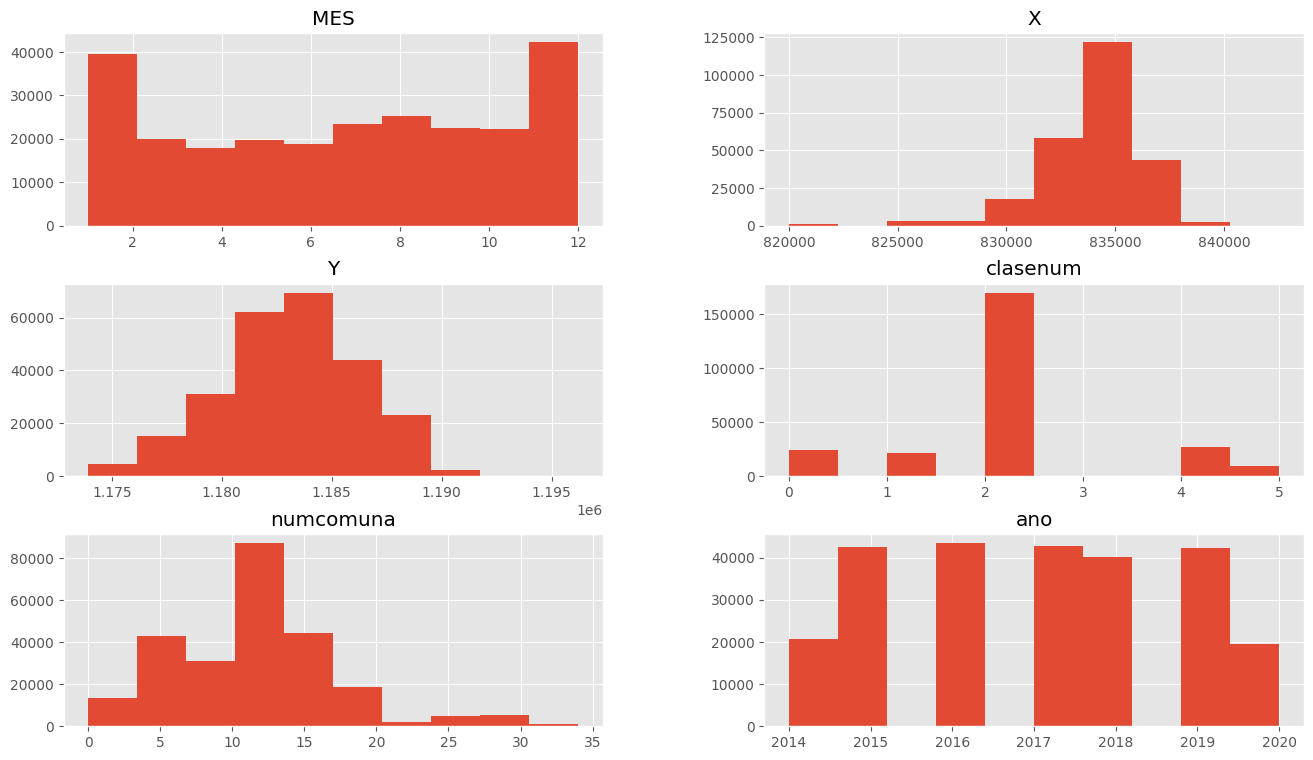

In [ ]:
dataframe2.hist()
plt.show()

#Se realiza una matriz de correlacion de pearson para revisar una posible relacion entre variables
Se puede ver que hay cierta correlacion entre los accidentes y la posicion en la ciudad y las comunas

<Axes: title={'center': 'Pearson Correlation of Features'}>

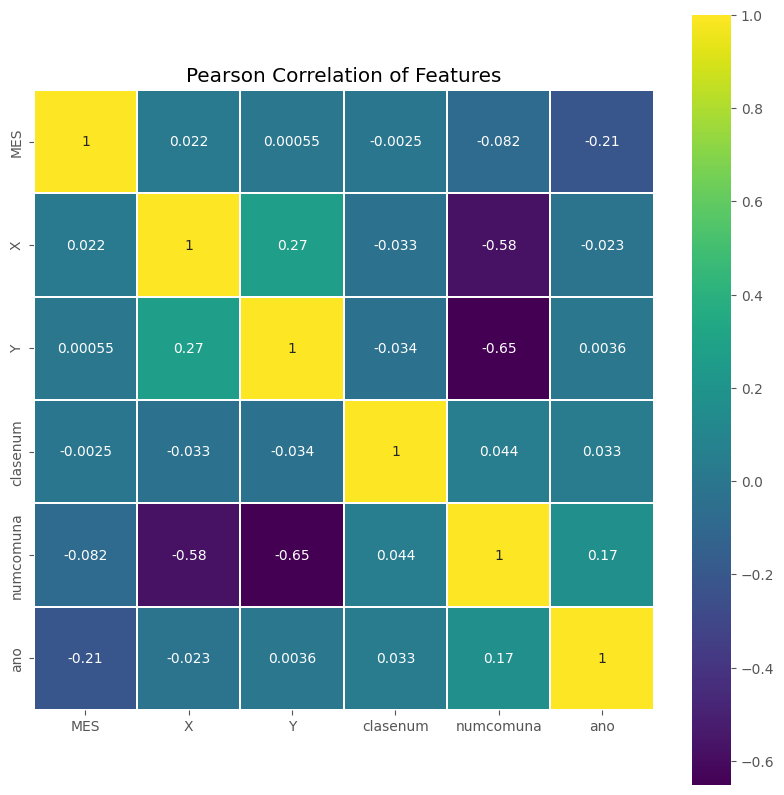

In [ ]:
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features')
sb.heatmap(dataframe2.astype(float).corr(),
           vmax=1.0,
           cmap=colormap,
           annot=True,
           linewidths=0.1,
           linecolor='white',
           square=True)

Las posibles correlaciones observadas estan dentro de lo predecible así que es favorable continuar

#Entropía e indice de Gini
Esto es necesario para el algoritmo mas adelante

In [ ]:
#Característica objetivo: Droga

#Mezclar datos
dataframe2=dataframe2.sample(frac=1).reset_index(drop=True)

#Todos los datos excepto la caracteristica Droga
X = dataframe2.drop(['clasenum'], axis=1)

#CARACTERÍSTICA OBJETIVO
y = dataframe2['clasenum']

#¿Cuáles serían las características/atributos/variables que puede ser posibles candidatos al nodo raíz? Se debe analizar una hipótesis con el análisis exploratorio

X = np.array(X)
y = np.array(y)

#Primero se revisa la entropía

In [ ]:
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=1)
accuracies = list()
max_attributes = len(list(dataframe))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced')
    for train_index, valid_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[valid_index]
        y_train, y_test = y[train_index], y[valid_index]

        model = tree_model.fit(X_train, y_train)
        valid_acc = model.score(X_test, y_test) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    # almacenamos acc promedio para cada profundidad
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)

# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

 Max Depth  Average Accuracy
         1          0.489987
         2          0.406336
         3          0.507154
         4          0.555210
         5          0.605384
         6          0.620606
         7          0.615631
         8          0.614104
         9          0.611247
        10          0.606099
        11          0.599227
        12          0.595507
        13          0.590655


#Luego el indice de Gini

In [ ]:
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=1)
accuracies = list()
max_attributes = len(list(dataframe))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='gini',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced')
    for train_index, valid_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[valid_index]
        y_train, y_test = y[train_index], y[valid_index]

        model = tree_model.fit(X_train, y_train)
        valid_acc = model.score(X_test, y_test) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    # almacenamos acc promedio para cada profundidad
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)

# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

 Max Depth  Average Accuracy
         1          0.494199
         2          0.468164
         3          0.506071
         4          0.584497
         5          0.613759
         6          0.616862
         7          0.609941
         8          0.611148
         9          0.606862
        10          0.604399
        11          0.600163
        12          0.598685
        13          0.596172


Lo anterior se hace como una formalidad, por lo general el indice de Gini va a dar siempre resultados mejores. Aquí es interesante resaltar que ambos datos estan arrojando la precision esperada de forma heurística para los diferentes niveles posibles de un arbol de decision (que es el principio en el que se basa este algoritmo), cabe resaltar que despues del octavo nivel se empieza a perder precisión.

#A continuación se haran pruebas para decidir la cantidad de datos que se usarán para entrenamiento y para pruebas
El formato a presentar será Entrenamiento/Prueba, el output del primer bloque (el de agrupamiento) puede ignorarse, aquí interesa ver el resultado del segundo bloque y ver cual se comporta mejor. Nótese que aquí se usa el índice de Gini.

#90/10

In [ ]:
X = dataframe2.drop(['clasenum'], axis=1)

#Atributo OBJETIVO
y = dataframe2['clasenum']

# Dividimos los datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.1, #90% datos de entrenamiento, 10% prueba
                                                    stratify = y,
                                                    random_state = 1)
# Datos de entrenaminto
conteo = X_train.copy()
conteo['label'] = y_train
conteo.groupby('label').size()

label
0     3209
1     2294
2    23529
3        5
4     5354
5     2148
dtype: int64

In [ ]:
decision_tree = tree.DecisionTreeClassifier(criterion='gini',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced')

# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)
y_pred_train = decision_tree.predict(X_train)

#Porcentaje de Exactitud con los datos de entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))

y_pred_test = decision_tree.predict(X_test)

#Porcentaje de Exactitud con pruebas
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))

Exactitud con datos de entrenamiento: 0.66
Exactitud con datos de pruebas: 0.61


#80/20

In [ ]:
X = dataframe2.drop(['clasenum'], axis=1)

#Atributo OBJETIVO
y = dataframe2['clasenum']

# Dividimos los datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2, #80% datos de entrenamiento, 20% prueba
                                                    stratify = y,
                                                    random_state = 1)
# Datos de entrenaminto
conteo = X_train.copy()
conteo['label'] = y_train
conteo.groupby('label').size()

label
0     2853
1     2039
2    20914
3        4
4     4759
5     1910
dtype: int64

In [ ]:
decision_tree = tree.DecisionTreeClassifier(criterion='gini',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced')

# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)
y_pred_train = decision_tree.predict(X_train)

#Porcentaje de Exactitud con los datos de entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))

y_pred_test = decision_tree.predict(X_test)

#Porcentaje de Exactitud con pruebas
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))

Exactitud con datos de entrenamiento: 0.67
Exactitud con datos de pruebas: 0.61


#70/30

In [ ]:
X = dataframe2.drop(['clasenum'], axis=1)

#Atributo OBJETIVO
y = dataframe2['clasenum']

# Dividimos los datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, #70% datos de entrenamiento, 30% prueba
                                                    stratify = y,
                                                    random_state = 1)
# Datos de entrenaminto
conteo = X_train.copy()
conteo['label'] = y_train
conteo.groupby('label').size()

label
0     2496
1     1784
2    18300
3        4
4     4164
5     1671
dtype: int64

In [ ]:
decision_tree = tree.DecisionTreeClassifier(criterion='gini',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced')

# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)
y_pred_train = decision_tree.predict(X_train)

#Porcentaje de Exactitud con los datos de entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))

y_pred_test = decision_tree.predict(X_test)

#Porcentaje de Exactitud con pruebas
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))

Exactitud con datos de entrenamiento: 0.66
Exactitud con datos de pruebas: 0.60


#Es más que evidente que 80/20 es la mejor opción

#Se seleccionan los K mejores atributos (KBest)
Esto es necesario para la construcción del arbol de decisiones. Aqui interesa la exactitud, si hay repetidos se toma el menor k con la mayor exactitud

In [ ]:
#Todos los datos excepto la caracteristica objetivo.
X = dataframe2.drop(['clasenum'], axis=1)
#CARACTERÍSTICA OBJETIVO

y = dataframe2['clasenum']

best=SelectKBest(k=len(list(dataframe2))-1)

X_new = best.fit_transform(X, y)
X_new.shape
selected = best.get_support(indices=True)
print(X.columns[selected])

Index(['DIA', 'CBML', 'MES', 'LONGITUD', 'LATITUD', 'gravenum', 'comunum',
       'disenum'],
      dtype='object')


n=3 Atributos

In [ ]:
#Todos los datos excepto la caracteristica objetivo.
X = dataframe2.drop(['clasenum'], axis=1)

#CARACTERÍSTICA OBJETIVO
y = dataframe2['clasenum']

best=SelectKBest(k=3)


X_new = best.fit_transform(X, y)
X_new.shape
selected = best.get_support(indices=True)
print(X.columns[selected])

Index(['MES', 'gravenum', 'disenum'], dtype='object')


In [ ]:
dataframe2.columns

Index(['DIA', 'CBML', 'MES', 'LONGITUD', 'LATITUD', 'clasenum', 'gravenum',
       'comunum', 'disenum'],
      dtype='object')

In [ ]:
#Todos los datos excepto la caracteristica clasenum (se omiten los atributos seleccionados por Kbest)
X = dataframe2.drop(['DIA','CBML','LONGITUD','LATITUD','comunum'], axis=1)

#Atributo OBJETIVO
y = dataframe2['clasenum']

# Dividimos los datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.8, #80% datos de entrenamiento, 20% prueba
                                                    stratify = y,
                                                    random_state = 1)
# Datos de entrenaminto
conteo = X_train.copy()
conteo['label'] = y_train
conteo.groupby('label').size()

label
0     713
1     510
2    5228
3       1
4    1190
5     477
dtype: int64

In [ ]:
decision_tree = tree.DecisionTreeClassifier(criterion='gini',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced')

# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)
y_pred_train = decision_tree.predict(X_train)

#Porcentaje de Exactitud con los datos de entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))

y_pred_test = decision_tree.predict(X_test)

#Porcentaje de Exactitud con pruebas
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))

Exactitud con datos de entrenamiento: 0.99
Exactitud con datos de pruebas: 1.00


n=4 atributos

In [ ]:
#Todos los datos excepto la caracteristica objetivo.
X = dataframe2.drop(['clasenum'], axis=1)

#CARACTERÍSTICA OBJETIVO
y = dataframe2['clasenum']

best=SelectKBest(k=4)


X_new = best.fit_transform(X, y)
X_new.shape
selected = best.get_support(indices=True)
print(X.columns[selected])

Index(['MES', 'LATITUD', 'gravenum', 'disenum'], dtype='object')


In [ ]:
dataframe2.columns

Index(['DIA', 'CBML', 'MES', 'LONGITUD', 'LATITUD', 'clasenum', 'gravenum',
       'comunum', 'disenum'],
      dtype='object')

In [ ]:
#Todos los datos excepto la caracteristica clasenum (se omiten los atributos seleccionados por Kbest)
X = dataframe2.drop(['DIA','CBML','LONGITUD','comunum'], axis=1)

#Atributo OBJETIVO
y = dataframe2['clasenum']

# Dividimos los datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.8, #80% datos de entrenamiento, 20% prueba
                                                    stratify = y,
                                                    random_state = 1)
# Datos de entrenaminto
conteo = X_train.copy()
conteo['label'] = y_train
conteo.groupby('label').size()

label
0     713
1     510
2    5228
3       1
4    1190
5     477
dtype: int64

In [ ]:
decision_tree = tree.DecisionTreeClassifier(criterion='gini',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced')

# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)
y_pred_train = decision_tree.predict(X_train)

#Porcentaje de Exactitud con los datos de entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))

y_pred_test = decision_tree.predict(X_test)

#Porcentaje de Exactitud con pruebas
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))

Exactitud con datos de entrenamiento: 1.00
Exactitud con datos de pruebas: 1.00


No es necesario revisar mas combinaciones

#Se definen las alturas del arbol de decisión

In [ ]:
X = dataframe2.drop(['clasenum'], axis=1)
y = dataframe2['clasenum']

In [ ]:
#Para usar este método X y 'y' deben ser listas np
X=np.array(X)
y=np.array(y)

cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=1)
accuracies = list()
max_attributes = len(list(dataframe))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='gini',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced')
    for train_index, valid_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[valid_index]
        y_train, y_test = y[train_index], y[valid_index]

        model = tree_model.fit(X_train, y_train)
        valid_acc = model.score(X_test, y_test) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    # almacenamos acc promedio para cada profundidad
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)

# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

 Max Depth  Average Accuracy
         1          0.494199
         2          0.468164
         3          0.506071
         4          0.584497
         5          0.613759
         6          0.616912
         7          0.609991
         8          0.611099
         9          0.606739
        10          0.604523
        11          0.600409
        12          0.598365
        13          0.596049


#Arbol de Decisión

In [ ]:
X = dataframe2.drop(['clasenum'], axis=1)
y = dataframe2['clasenum']

# Dividimos los datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2, #80% datos de entrenamiento, 20% prueba
                                                    stratify = y,
                                                    random_state = 1)

In [ ]:
conteo = X_train.copy()
conteo['label'] = y_train
conteo.groupby('label').size()

label
0     2853
1     2039
2    20914
3        4
4     4759
5     1910
dtype: int64

In [ ]:
# Instanciar Arbol de decision con profundidad = 5
decision_tree = tree.DecisionTreeClassifier(criterion='gini',
                                            #Restricciones que evitan Overfitting.
                                            min_samples_split=5,
                                            min_samples_leaf=2,
                                            max_depth = 6,
                                            class_weight='balanced')  #Balanceo automático

In [ ]:
# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)

#Cada cambio que se haga requiere analizar o tener en cuenta su nivel de exactitud.

#Exactitud

#Datos de entrenamiento
y_pred_train = decision_tree.predict(X_train)

#Porcentaje de exactitud con los datos de entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))

#Datos de prueba
y_pred_test = decision_tree.predict(X_test)

#Porcentaje de exactitud con pruebas
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))

Exactitud con datos de entrenamiento: 0.63
Exactitud con datos de pruebas: 0.63


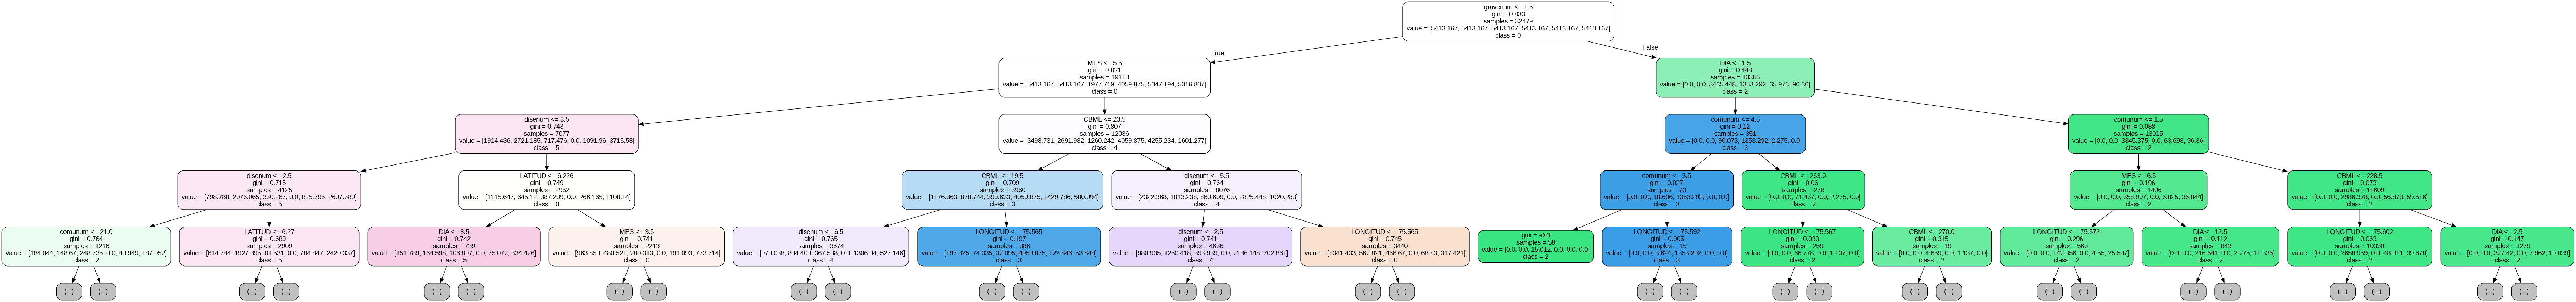

In [ ]:
# exportar el modelo a archivo .dot y graficar
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = True,
                              feature_names = list(dataframe2.drop(['clasenum'], axis=1)),
                              class_names = ['0','1','2','3','4','5'],
                              rounded = True,
                              filled= True )

# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

#F1-Score
Con esto se pretende dar un vistazo al comportamiento de los niveles, no se esperan valores perfectos ni tiene ninguna influencia en el programa

#F1-Score Para datos de entrenamiento

In [ ]:
decoded_y_test = y_train
decoded_predictions = decision_tree.predict(X_train)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.21      0.51      0.30      2853
           1       0.25      0.14      0.18      2039
           2       0.97      0.73      0.83     20914
           3       0.03      1.00      0.05         4
           4       0.55      0.56      0.55      4759
           5       0.23      0.47      0.31      1910

    accuracy                           0.63     32479
   macro avg       0.37      0.57      0.37     32479
weighted avg       0.75      0.63      0.67     32479



#F1-Score Para datos de prueba

In [ ]:
decoded_y_test = y_test
decoded_predictions = decision_tree.predict(X_test)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.21      0.47      0.29       713
           1       0.27      0.15      0.19       510
           2       0.96      0.74      0.84      5229
           3       0.00      0.00      0.00         1
           4       0.54      0.57      0.56      1190
           5       0.20      0.40      0.26       477

    accuracy                           0.63      8120
   macro avg       0.36      0.39      0.36      8120
weighted avg       0.75      0.63      0.67      8120



#Prediccion

Se crea un dataframe dummy para predecir, los datos no requieren ser reales, solo deben tener sentido en el formato de sus clases

In [ ]:
#Predicción usando una semilla
data = {'Dia':[10,29,21],
        'CBML':[112,300,295],
        'MES':[11,8,2],
        'LONGITUD':[-75.565421,-75.583143,-75.563121],
        'LATITUD':[6.230148,6.251814,6.262301],
        'clasenum':[4,3,3],
        'gravenum':[0,1,0],
        'comunum':[21,14,8],
        'disenum':[2,2,9]}
prueba = pd.DataFrame(data)

In [ ]:
x_test=pd.DataFrame(columns=('clasenum', 'DIA',	'CBML',	'MES',	'LONGITUD',	'LATITUD',	'gravenum',	'comunum',	'disenum'))
x_test.loc[0]=(4,10,112,11,-75.565421,6.230148,0,21,2)    #El primer dato es de clasenum y no importa, ya que ese valor es el que se va a predecir
y_pred = decision_tree.predict(x_test.drop(['clasenum'], axis = 1)) #Saca 'clasenum':  Característica obj
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['clasenum'], axis = 1))

Prediccion: [2]


#Funcion para predecir datos en masa
Requiere retoque

In [ ]:
def pred(n):
    dataframeaux={'pred'}
    da=pd.DataFrame(dataframeaux)
    x_test=pd.DataFrame(columns=('clasenum', 'DIA',	'CBML',	'MES',	'LONGITUD',	'LATITUD',	'gravenum',	'comunum',	'disenum'))
    x_test.loc[0]=(4,10,112,11,-75.565421,6.230148,0,21,2)    #El primer dato es de clasenum y no importa, ya que ese valor es el que se va a predecir
    for i in range (n):
      y_pred = decision_tree.predict(x_test.drop(['clasenum'], axis = 1)) #Saca 'clasenum':  Característica obj
      da.loc[len(da.index)] = [y_pred]
    return da
pred(1000)

,0
0,pred
1,[2]
2,[2]
3,[2]
4,[2]
...,...
996,[2]
997,[2]
998,[2]
999,[2]
